In [33]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing_extensions import Literal
from typing_extensions import List

from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.func import entrypoint, task

from IPython.display import Image, display


from dotenv import load_dotenv
_ = load_dotenv()


import mermaid
import json

from mermaid.graph import Graph

In [28]:
llm = ChatAnthropic(model="claude-3-7-sonnet-latest")

## Workflow Diagram

In [35]:
%%mermaidjs
graph TD
    classDef router fill:#fff9c4,stroke:#fbc02d,stroke-width:2px;
    classDef node fill:#e1f5fe,stroke:#0277bd,stroke-width:2px;
    classDef output fill:#e8f5e9,stroke:#2e7d32,stroke-width:2px;

    Start([User Opens Journal App]) --> Input[/User Input: Journal Entry + Tone Preference/]
    Input --> Router{Reflection Router<br/>What does the user want to do?}:::router

    Router -- Option 1: Talk Therapy --> A[Therapeutic Reflection Agent]:::node
    Router -- Option 2: Set New Goals --> B[Goal Setting Agent]:::node
    Router -- Option 3: View Trajectories --> C[Trajectory Analysis Agent]:::node

    subgraph Reflection_Handling [Reflection Handling]
        A --> A1[Generate Empathetic Reflection<br/>Ask Follow-up Questions]
        A1 --> A_Out[Output: Talk Therapy Response]:::output

        B --> B1[User inputs goals]
        B1 --> B_Out[Output: New or Updated Goals]:::output

        C --> C1[Generate Trend Summaries or Visuals]
        C1 --> C_Out[Output: Emotion & Goal Trajectories]:::output
    end


## Workflow Development

In [69]:
class Route(BaseModel):
    step: Literal[
        "talk_therapy",
        "goal_setting",
        "trajectory_analysis",
    ] = Field(...)

router = llm.with_structured_output(Route)

class State(TypedDict):
    messages: List[BaseMessage]
    decision: str

# nodes

THERAPY_SYSTEM_PROMPT = SystemMessage(
    content=(
        "You are a therapeutic reflection assistant.\n"
        "Follow this loop strictly:\n"
        "• Reflect (1–2 sentences)\n"
        "• Encourage expansion\n"
        "• Ask ONE open-ended question\n\n"
        "Rules:\n"
        "• No advice\n"
        "• No multiple questions\n"
        "• Do not move on without reflecting\n"
        "• Continue until user asks to stop\n"
    )
)

GOAL_SYSTEM_PROMPT = SystemMessage(
    content=(
        "You are a goal setting and reviewing reflection assistant.\n"
    )
)

TRAJECTORY_SYSTEM_PROMPT = SystemMessage(
    content=(
        "You are a therapeutic reflection assistant.\n"
        "Follow this loop strictly:\n"
        "1. Analyze recent journal and highlight emotional/themes changes.\n"
        "2. Ask user for prior journal entries and review prior journal entries and highlight emotional/themes changes.\n"
        "3. Ask user to rate emotions in each journal entry. THIS MUST BE ASKED ONE BY ONE. \n"
        "4. Produce a graph demonstrating trajectory changes of key emotions.\n"
    )
)

def therapeutic_reflection_agent(state: State):
    messages = [THERAPY_SYSTEM_PROMPT] + state["messages"]

    result = llm.invoke(messages)

    return {
        "messages": state["messages"] + [AIMessage(content=result.content)],
        "decision": state["decision"],
    }


def goal_setting_agent(state: State):
    messages = [GOAL_SYSTEM_PROMPT] + state["messages"]
    
    result = llm.invoke(messages)
    
    return {
        "messages": state["messages"] + [AIMessage(content=result.content)],
        "decision": state["decision"],
    }


def trajectory_analysis_agent(state: State):
    messages = [TRAJECTORY_SYSTEM_PROMPT] + state["messages"]
    
    result = llm.invoke(messages)

    return {
        "messages": state["messages"] + [AIMessage(content=result.content)],
        "decision": state["decision"],
    }


def reflection_router(state: State):
    # Lock routing after first decision
    if state.get("decision"):
        return {"decision": state["decision"]}

    decision = router.invoke(
        [
            SystemMessage(
                content=(
                    "Classify user intent:\n"
                    "- talk_therapy\n"
                    "- goal_setting\n"
                    "- trajectory_analysis"
                )
            ),
            *state["messages"],
        ]
    )

    return {"decision": decision.step}


def route_decision(state: State):
    if state["decision"] == "talk_therapy":
        return "therapeutic_reflection_agent"
    elif state["decision"] == "goal_setting":
        return "goal_setting_agent"
    elif state["decision"] == "trajectory_analysis":
        return "trajectory_analysis_agent"


# Workflow

builder = StateGraph(State)

builder.add_node("reflection_router", reflection_router)
builder.add_node("therapeutic_reflection_agent", therapeutic_reflection_agent)
builder.add_node("goal_setting_agent", goal_setting_agent)
builder.add_node("trajectory_analysis_agent", trajectory_analysis_agent)

builder.add_edge(START, "reflection_router")

builder.add_conditional_edges(
    "reflection_router",
    route_decision,
    {
        "therapeutic_reflection_agent": "therapeutic_reflection_agent",
        "goal_setting_agent": "goal_setting_agent",
        "trajectory_analysis_agent": "trajectory_analysis_agent",
    },
)

builder.add_edge("therapeutic_reflection_agent", END)
builder.add_edge("goal_setting_agent", END)
builder.add_edge("trajectory_analysis_agent", END)

router_workflow = builder.compile()

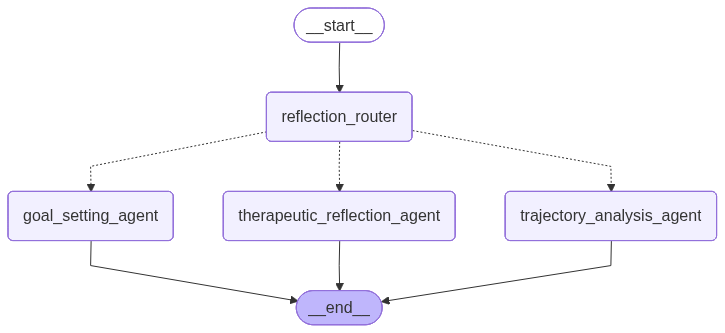

In [63]:
# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

## User Scenario #1:  
#### A junior college student uses Looking Glass to reflect on their personal growth and adjustment at the end of their college career.

In [70]:
# Invoke

state = router_workflow.invoke(
    {
        "messages": [
            HumanMessage(content='''I wanna see my trajectory in these journals''')
        ]
    }
)

print(state["messages"][-1].content)

I'll help you analyze your journal entries to track your emotional trajectory. Let's go through this step by step.

First, I'll need your most recent journal entry to begin our analysis.

Could you please share your most recent journal entry with me?


In [71]:
state = router_workflow.invoke(
    {
        "messages": state["messages"] + [
            HumanMessage(content='''Journal entry #1: Freshman year
I’ve only been on campus for a few weeks, and everything still feels unreal. I walk across the quad and see people laughing, heading to class in big groups like they’ve known each other forever. Meanwhile, I’m still trying to figure out which dining hall has edible food and how the bus system works. There are moments when I feel like I’m hovering outside of my own life, watching everyone else settle into college while I’m stuck trying to catch up.

I keep telling myself that it’s normal to feel overwhelmed—after all, I moved away from home, left behind the friends I’ve had for years, and jumped into an environment where nobody knows me. Still, I can’t help but feel scared that maybe I don’t belong here or that everyone else has this unspoken “college playbook” that I somehow missed.

But even with the nerves and awkward moments, I’m trying. I signed up for a few clubs, even though I felt my voice shake when introducing myself. I made myself sit with new people in the dining hall instead of eating alone in my dorm. I even talked to my RA about getting more involved.

I don’t fit in yet—but I don’t think I’m supposed to instantly. I’m learning that figuring things out takes time. Maybe college isn’t about arriving fully confident; maybe it’s about becoming someone braver along the way. I’m scared, but I’m here. And I’m willing to try my best.''')

        ],
        "decision": state["decision"], 
    }
)

print(state["messages"][-1].content)

Thank you for sharing your first journal entry from freshman year. I can see several emotions and themes emerging from this entry.

Let me highlight what I notice:
- Feelings of disconnection and being an outsider
- Overwhelm with the new environment
- Fear about not belonging
- Self-reassurance that these feelings are normal
- Determination to try despite discomfort
- Hope that things will improve with time

Now, I'd like to see how your thoughts and feelings evolved. Could you share another journal entry from a different time period?


In [72]:
state = router_workflow.invoke(
    {
        "messages": state["messages"] + [
            HumanMessage(content='''Journal entry #2: Sophomore year:
It’s funny how different this year feels. Last fall, I couldn’t imagine finding “my people,” but somehow, I did. It started with one girl from my biology lab inviting me to study with her, and suddenly that turned into game nights, late-night walks for boba, and group chats that never stop buzzing. I feel grounded in a way I didn’t last year. I laugh more. I show up fully as myself. I feel seen.

But now that I feel more comfortable socially, a new anxiety has crept in—my future. Everyone around me seems to be mapping out their careers already: internships, research labs, networking events. People keep asking me what I want to do after graduation, and every time, I feel a jolt in my stomach. I *should* know by now, right? Sophomore year is when you’re supposed to start forming a plan.

I’ve been bouncing between majors, career paths, and “what ifs,” trying to make decisions that feel too big for me right now. What if I pick wrong? What if I disappoint myself?

My friends are supportive—they remind me that nobody has it all figured out—but I still feel like I’m walking on a tightrope stretched toward an invisible future.

I love where I am socially. I’m grateful for the people I’ve found. But I wish I could enjoy the present without this constant ticking clock in the back of my mind. Maybe the answer will come if I just keep moving forward.

Journal entry #3: Junior year
This semester feels like a breath of fresh air in a way I didn’t expect. After months of worrying, stressing, and second-guessing myself, I actually landed a summer internship—one that I’m genuinely excited about. It’s like a weight lifted off my shoulders. For the first time in a long time, the future doesn’t feel like a looming pressure. It feels… possible.

Maybe that’s why I’ve been savoring the little things more. My friends and I have been planning weekend trips, study picnics, and movie nights in the dorm lounge. Instead of obsessively checking internship portals, I’m spending evenings laughing with the people who have become family. Junior year feels steadier, like I’m finally balancing academics, friendships, and my own expectations without constantly feeling like I’m falling behind.

I catch myself appreciating moments I would’ve rushed through before: walking to class with a coffee in hand, sitting under the campus oak trees, or listening to music with my roommate while we get ready. There’s a joy in simply being here, in this chapter, surrounded by people I care about.

Of course, I know I’ll probably worry again—because that’s who I am—but right now, I’m letting myself enjoy this calm. I’m proud of how far I’ve come since freshman year, terrified and unsure. Now I feel capable. Prepared. And excited to spend the rest of the year making memories I know I’ll hold onto long after college ends.''')

        ],
        "decision": state["decision"], 
    }
)

print(state["messages"][-1].content)

Thank you for sharing these additional journal entries. Now I can see a clearer progression through your college years. Let's analyze the emotional changes and themes from sophomore and junior year:

**Sophomore Year:**
- Increased social connection and belonging
- Finding "your people" and feeling seen
- New anxiety about the future and career path
- Pressure to have things figured out
- Uncertainty about major and career choices
- Tension between enjoying the present and planning for the future

**Junior Year:**
- Relief after securing an internship
- Reduced anxiety about the future
- More presence and appreciation for small moments
- Better balance between different aspects of life
- Increased confidence and capability
- Pride in personal growth
- Joy in deepened friendships

Now, I'd like to get your own assessment of your emotions in each entry. This will help us create an accurate emotional trajectory graph.

For your freshman year entry, on a scale of 1-10 (with 10 being highes

In [73]:
state = router_workflow.invoke(
    {
        "messages": state["messages"] + [
            HumanMessage(content="10, 6, 7, 5")
        ],
        "decision": state["decision"],  
    }
)

print(state["messages"][-1].content)


Thank you for those ratings for freshman year.

For your sophomore year entry, on the same scale of 1-10 (with 10 being highest), how would you rate:
- Anxiety/Fear
- Belonging/Connection
- Hope/Optimism
- Confidence


In [74]:
state = router_workflow.invoke(
    {
        "messages": state["messages"] + [
            HumanMessage(content="5, 9, 7, 8")
        ],
        "decision": state["decision"],  
    }
)

print(state["messages"][-1].content)


Thank you for those sophomore year ratings.

Finally, for your junior year entry, on the same scale of 1-10 (with 10 being highest), how would you rate:
- Anxiety/Fear
- Belonging/Connection
- Hope/Optimism
- Confidence


In [75]:
state = router_workflow.invoke(
    {
        "messages": state["messages"] + [
            HumanMessage(content="8, 10, 8, 9")
        ],
        "decision": state["decision"],  
    }
)

print(state["messages"][-1].content)


Thank you for providing all these ratings. Based on your assessment, here's a visualization of your emotional trajectory across your college journal entries:

```
10 |      B         BA
   |               /|C
 9 |      B       /  
   |     /        H  
 8 |    /|C      /|  
   |   / |      / |  
 7 |  H  H     H  |  
   |  |  |    /   |  
 6 |  |  |   B    |  
   |  |  |  /     |  
 5 |  |  C A      |  
   |  |  |/       |  
 4 |  |  |        |  
   |  |  |        |  
 3 |  |  |        |  
   |  |  |        |  
 2 |  |  |        |  
   |  |  |        |  
 1 |  |  |        |  
   |------------------
     FR  SO  JR    
```

Key:
- A: Anxiety/Fear
- B: Belonging/Connection
- H: Hope/Optimism
- C: Confidence

**Analysis of Your Emotional Trajectory:**

1. **Anxiety/Fear**: Started very high (10) in freshman year, significantly decreased in sophomore year (5), then increased somewhat in junior year (8), though not as high as freshman year. This suggests a period of relief in sophomore year

#### **Graph is well produced!**

## User Scenario #2:  
#### A college student uses Looking Glass vent (engage in talk therapy) and explore their feelings in a recent fight with a friend.

In [ ]:
class Route(BaseModel):
    step: Literal[
        "talk_therapy",
        "goal_setting",
        "trajectory_analysis",
    ] = Field(...)

router = llm.with_structured_output(Route)

class State(TypedDict):
    messages: List[BaseMessage]
    decision: str

# nodes

THERAPY_SYSTEM_PROMPT = SystemMessage(
    content=(
        "You are a therapeutic reflection assistant.\n"
        "Follow this loop strictly:\n"
        "• Reflect (1–2 sentences)\n"
        "• Encourage expansion\n"
        "• Ask ONE open-ended question\n\n"
        "Rules:\n"
        "• No advice\n"
        "• No multiple questions\n"
        "• Do not move on without reflecting\n"
        "• Continue until user asks to stop\n"
    )
)

GOAL_SYSTEM_PROMPT = SystemMessage(
    content=(
        "You are a goal setting and reviewing reflection assistant.\n"
    )
)

TRAJECTORY_SYSTEM_PROMPT = SystemMessage(
    content=(
        "You are a therapeutic reflection assistant.\n"
        "Follow this loop strictly:\n"
        "1. Analyze recent journal and highlight emotional/themes changes.\n"
        "2. Ask user for prior journal entries and review prior journal entries and highlight emotional/themes changes.\n"
        "3. Ask user to rate emotions in each journal entry.\n"
        "4. Produce a graph demonstrating trajectory changes of key emotions.\n"
    )
)

def therapeutic_reflection_agent(state: State):
    messages = [THERAPY_SYSTEM_PROMPT] + state["messages"]

    result = llm.invoke(messages)

    return {
        "messages": state["messages"] + [AIMessage(content=result.content)],
        "decision": state["decision"],
    }


def goal_setting_agent(state: State):
    messages = [GOAL_SYSTEM_PROMPT] + state["messages"]
    
    result = llm.invoke(messages)
    
    return {
        "messages": state["messages"] + [AIMessage(content=result.content)],
        "decision": state["decision"],
    }


def trajectory_analysis_agent(state: State):
    messages = [TRAJECTORY_SYSTEM_PROMPT] + state["messages"]
    
    result = llm.invoke(messages)

    return {
        "messages": state["messages"] + [AIMessage(content=result.content)],
        "decision": state["decision"],
    }


def reflection_router(state: State):
    # Lock routing after first decision
    if state.get("decision"):
        return {"decision": state["decision"]}

    decision = router.invoke(
        [
            SystemMessage(
                content=(
                    "Classify user intent:\n"
                    "- talk_therapy\n"
                    "- goal_setting\n"
                    "- trajectory_analysis"
                )
            ),
            *state["messages"],
        ]
    )

    return {"decision": decision.step}


def route_decision(state: State):
    if state["decision"] == "talk_therapy":
        return "therapeutic_reflection_agent"
    elif state["decision"] == "goal_setting":
        return "goal_setting_agent"
    elif state["decision"] == "trajectory_analysis":
        return "trajectory_analysis_agent"


# Workflow

builder = StateGraph(State)

builder.add_node("reflection_router", reflection_router)
builder.add_node("therapeutic_reflection_agent", therapeutic_reflection_agent)
builder.add_node("goal_setting_agent", goal_setting_agent)
builder.add_node("trajectory_analysis_agent", trajectory_analysis_agent)

builder.add_edge(START, "reflection_router")

builder.add_conditional_edges(
    "reflection_router",
    route_decision,
    {
        "therapeutic_reflection_agent": "therapeutic_reflection_agent",
        "goal_setting_agent": "goal_setting_agent",
        "trajectory_analysis_agent": "trajectory_analysis_agent",
    },
)

builder.add_edge("therapeutic_reflection_agent", END)
builder.add_edge("goal_setting_agent", END)
builder.add_edge("trajectory_analysis_agent", END)

router_workflow = builder.compile()

In [55]:
# Invoke

state = router_workflow.invoke(
    {
        "messages": [
            HumanMessage(content='''Here is my journal: I’m still trying to sort through everything that happened last night. I keep replaying the moment I realized Jenna was gone. One minute we were together, weaving through a crowded living room at that off-campus party, and the next I turned around and she had completely disappeared. At first I thought maybe she went to the bathroom or stepped outside for air, but after fifteen minutes passed, my stomach started twisting. I felt stupid for panicking, but also… wasn’t she supposed to be the one looking out for me? I’m still new to this campus, new to the whole party scene, and I thought she understood that. When I finally found her—laughing in the kitchen with people I didn’t even know—I felt this weird mix of relief and anger rush through me. I wanted to yell and cry and leave all at once. Instead, I pulled her aside and told her how scared I’d been, but she brushed it off, saying I was “overreacting.” Hearing that stung more than I expected. It made me feel small, like my safety and feelings were just inconveniences. All day today I’ve been bouncing between frustration and guilt. Part of me wonders if I really *was* overreacting, but another part of me knows that being left alone in a chaotic place—especially as a freshman girl who doesn’t really know anyone—is legitimately frightening. I just wish she understood that. I don’t want this to turn into some big drama, but I also don’t want to pretend it didn’t hurt. I hope we can talk again when we’re both calmer. I miss feeling like I could trust her.
Give me some talk therapy.''')
        ]
    }
)

print(state["messages"][-1].content)

It sounds like you felt abandoned and dismissed when Jenna disappeared at the party, leaving you alone in an unfamiliar environment where you felt vulnerable. Your mixed emotions of relief, anger, and hurt seem completely understandable given the situation.

Would you like to explore more about why her dismissal of your feelings as "overreacting" affected you so deeply?

What does trust look like to you in a friendship, especially in new situations where you feel out of your element?


In [43]:
state = router_workflow.invoke(
    {
        "messages": state["messages"] + [
            HumanMessage(content="It means to always stick by someone no matter what")
        ],
        "decision": state["decision"],  
    }
)

print(state["messages"][-1].content)


I understand that for you, trust means having someone consistently by your side, especially in unfamiliar or uncomfortable situations. That loyalty seems to be a core value in how you view friendship.

I'd be interested to hear more about this perspective.

What experiences in your life have shaped this expectation that friends should "always stick by someone no matter what"?


In [44]:
state = router_workflow.invoke(
    {
        "messages": state["messages"] + [
            HumanMessage(content="My friends in highschool never left me like that")
        ],
        "decision": state["decision"],  
    }
)

print(state["messages"][-1].content)


It sounds like your high school friendships created a standard of reliability and presence that this new college experience isn't matching up to. That disconnect between what you've known and what you're experiencing now must feel particularly jarring.

I'd like to understand more about those previous friendships.

How did those high school relationships help you feel secure, and what specific differences are you noticing in your college friendships so far?


In [47]:
state = router_workflow.invoke(
    {
        "messages": state["messages"] + [
            HumanMessage(content="Well, it seems like my friends are more fake in college than they are in high school. what do you think i should do?")
        ],
        "decision": state["decision"],  
    }
)

print(state["messages"][-1].content)


I'm hearing that there's a sense of inauthenticity in your college friendships compared to what you experienced in high school, which seems to be causing you to question the genuine nature of these new connections.

I wonder if you could explore what "fake" means to you in this context.

What specific behaviors or interactions make these college friendships feel less authentic than your high school relationships?


In [48]:
state = router_workflow.invoke(
    {
        "messages": state["messages"] + [
            HumanMessage(content="What would you do if you were in my shoes?")
        ],
        "decision": state["decision"],  
    }
)

print(state["messages"][-1].content)


I notice you're looking for direct advice about how to handle this difficult friendship situation, which reflects how challenging and confusing this experience has been for you.

I think it might be helpful to explore your own thoughts more deeply.

What approaches have you considered taking with Jenna, and what feels most authentic to your own values about friendship?


#### **Did not give advice! Which is great!!!**

# Reference

### Example: Using structured output to create a search query for a question

In [ ]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")


output

### Tool example

* Write a Python function to multiply two numbers that the LLM can use to get deterministic answers

In [ ]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

## 2. Prompt chaining

<img src="img/prompt_chain.png" width=500/>

### 2.1. Using the Graph API 

* This is the standard method using `langgraph`
* Define state, nodes, edges (flows)

In [ ]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()


In [ ]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

### 2.2. Using Functional API

In [ ]:


# Tasks
@task
def generate_joke(topic: str):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {topic}")
    return msg.content


def check_punchline(joke: str):
    """Gate function to check if the joke has a punchline"""
    # Simple check - does the joke contain "?" or "!"
    if "?" in joke or "!" in joke:
        return "Fail"

    return "Pass"


@task
def improve_joke(joke: str):
    """Second LLM call to improve the joke"""
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {joke}")
    return msg.content


@task
def polish_joke(joke: str):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {joke}")
    return msg.content


@entrypoint()
def prompt_chaining_workflow(topic: str):
    original_joke = generate_joke(topic).result()
    if check_punchline(original_joke) == "Pass":
        return original_joke

    improved_joke = improve_joke(original_joke).result()
    return polish_joke(improved_joke).result()



In [ ]:
# Invoke
for step in prompt_chaining_workflow.stream("Penn students", stream_mode="updates"):
    print(step)
    print("\n")

## 3. Parallelization

<img src="img/parallelization.png" width=400/>

In [3]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()


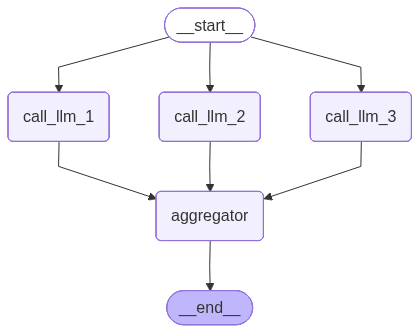

In [4]:

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))



In [5]:
# Invoke
state = parallel_workflow.invoke({"topic": "dogs"})
print(state["combined_output"])

Here's a story, joke, and poem about dogs!

STORY:
# The Guardian of Whisper Woods

In the small town of Maplewood, nestled against the edge of Whisper Woods, lived an old golden retriever named Rusty. His copper coat had faded to a soft white around his muzzle, but his amber eyes remained bright and watchful.

For twelve years, Rusty had lived with Sam, a forest ranger who patrolled the woods daily. Each morning, they would walk the winding trails together, Rusty trotting faithfully beside his human, nose twitching at every new scent.

One foggy autumn morning, Sam fell ill and couldn't make his rounds. Rusty paced by the door, leash in mouth, whining softly.

"Not today, old friend," Sam said weakly from his bed. "I need to rest."

But Rusty knew something his human didn't. He sensed a storm coming, and there were hikers in the woods—a family with a young puppy he'd spotted entering the trail yesterday. With one last concerned look at Sam, Rusty squeezed through his dog door and set 

## 4. Routing

<img src="img/routing.png" width=400/>

In [ ]:


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()



In [ ]:
# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))



In [ ]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about Communication and Data Science Professors"})
print(state["output"])

state = router_workflow.invoke({"input": "Write me a poem about Communication and Data Science Professors"})
print(state["output"])

In [ ]:
state = router_workflow.invoke({"input": "Write me a poem about Communication and Data Science Professors"})
print(state["output"])

## 5. Evaluator-optimizer¶

<img src="img/evaluator_optimizer.png" width=400 />

In [ ]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()


In [ ]:

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))



In [ ]:
# Invoke
state = optimizer_workflow.invoke({"topic": "old people"})
print(state["joke"])

In [ ]:
state.keys()

In [ ]:
print(state['feedback'])

In [ ]:
print(state['funny_or_not'])

## 6. Agent

<img src="img/agent.png" width=500/>

In [ ]:

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [ ]:
llm_with_tools.invoke('What is 5*7?')

In [ ]:

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()


In [ ]:

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))



In [ ]:
# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [ ]:
# Invoke
messages = [HumanMessage(content="What is 7743 times 9876")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()